In [ ]:
# pip install -U pip
# pip install gymnasium[box2d]
# pip install box2d
# pip install pygame
# pip install stable_baselines3 
# pip install --upgrade --force-reinstall stable-baselines3[extra]
# pip install tensorboard
# pip install imageio
# pip install torch --index-url https://download.pytorch.org/whl/cpu

In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import os

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

# ---------------------------
# Environment factory
# ---------------------------
def make_env():
    def _init():
        env = gym.make(
            "LunarLander-v3",
            continuous=False,
            gravity=-10.0,
            enable_wind=False,
            wind_power=15.0,
            turbulence_power=1.5
        )
        # Wrap with Monitor → logs monitor.csv automatically
        return Monitor(env)
    return _init

# Vectorized env
env = DummyVecEnv([make_env()])

# ---------------------------
# RL Model
# ---------------------------
model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=3e-4,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    target_update_interval=250,
    train_freq=4,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1,
    tensorboard_log="./lunar_tensorboard/"
)

# Storage for evaluation curve
eval_steps = []
eval_means = []
eval_stds = []

# ---------------------------
# Training Loop
# ---------------------------
total_timesteps = 200_000
step_chunk = 20_000

for t in range(0, total_timesteps, step_chunk):
    print(f"\n--- Training: {t+step_chunk} / {total_timesteps} steps ---")
    
    model.learn(
        total_timesteps=step_chunk,
        reset_num_timesteps=False
    )

    # Evaluate
    mean_reward, std_reward = evaluate_policy(
        model,
        make_env()(),
        n_eval_episodes=10,
        deterministic=True
    )

    eval_steps.append(t + step_chunk)
    eval_means.append(mean_reward)
    eval_stds.append(std_reward)

# Save model
model.save("dqn_lander_model")

env.close()


Using cpu device

--- Training: 20000 / 200000 steps ---
Logging to ./lunar_tensorboard/DQN_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 127      |
|    ep_rew_mean      | -174     |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3527     |
|    time_elapsed     | 0        |
|    total_timesteps  | 509      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 106      |
|    ep_rew_mean      | -193     |
|    exploration_rate | 0.585    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3626     |
|    time_elapsed     | 0        |
|    total_timesteps  | 847      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 113      |
|    ep_rew_mean      | -238   

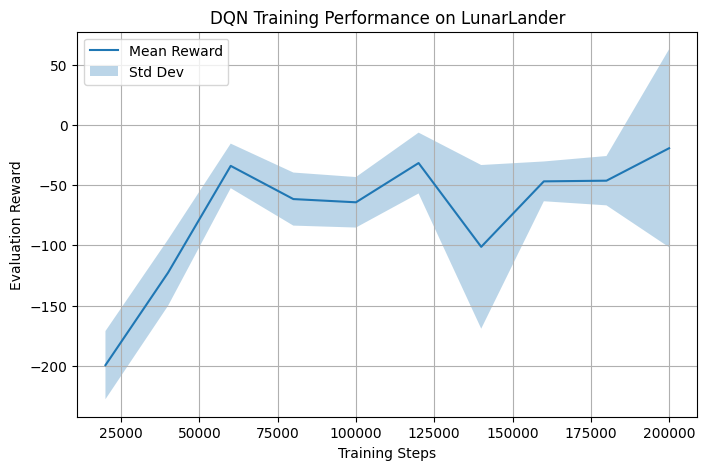

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(eval_steps, eval_means, label="Mean Reward")
plt.fill_between(
    eval_steps,
    [m - s for m, s in zip(eval_means, eval_stds)],
    [m + s for m, s in zip(eval_means, eval_stds)],
    alpha=0.3,
    label="Std Dev"
)

plt.xlabel("Training Steps")
plt.ylabel("Evaluation Reward")
plt.title("DQN Training Performance on LunarLander")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import imageio
import numpy as np
from stable_baselines3 import DQN
import gymnasium as gym

model = DQN.load("dqn_lander_model")

env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")
obs, _ = env.reset()

frames = []
done = False

while not done:
    frame = env.render()
    frames.append(frame)

    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# Save GIF
imageio.mimsave("lander_result.gif", frames, fps=30)
"GIF saved as lander_result.gif"

'GIF saved as lander_result.gif'

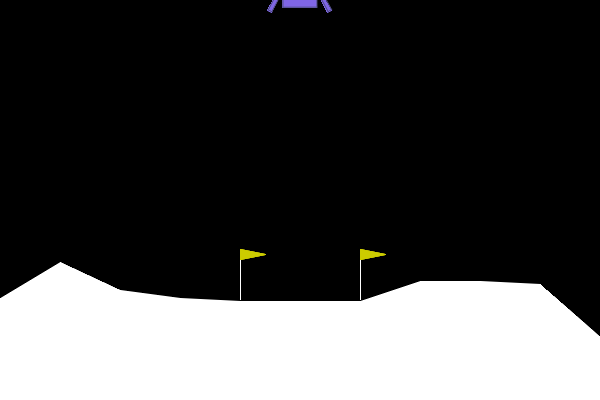

In [11]:
from IPython.display import Image, display
X = Image(filename="lander_result.gif", format='gif')
display(X)

The lander hovers around the target area but has not learned the landing! Additionally, mean reward still does not look good and showed some improvement when we stopped training.

## Experiment A — Increase training on DQN

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

def make_env():
    def _init():
        env = gym.make("LunarLander-v3", continuous=False,
                       gravity=-10.0, enable_wind=False,
                       wind_power=15.0, turbulence_power=1.5)
        return Monitor(env)
    return _init

env = DummyVecEnv([make_env()])

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-4,           
    buffer_size=500_000,          
    learning_starts=10_000,       
    batch_size=64,
    gamma=0.99,
    train_freq=1,                 # update every step (can speed learning)
    target_update_interval=1000,  # update target network less often for stability
    policy_kwargs=dict(net_arch=[256,256]),  # bigger network
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1,
    tensorboard_log="./lunar_tensorboard/"
)

model.learn(total_timesteps=500_000)  # train longer 
model.save("dqn_lunarlander_tuned")
env.close()


Using cpu device
Logging to ./lunar_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 96       |
|    ep_rew_mean      | -109     |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2784     |
|    time_elapsed     | 0        |
|    total_timesteps  | 384      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.1     |
|    ep_rew_mean      | -126     |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2890     |
|    time_elapsed     | 0        |
|    total_timesteps  | 713      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.3     |
|    ep_rew_mean      | -183     |
|    exploration_rate | 0.978    |
|

In [ ]:
import imageio
import numpy as np
from stable_baselines3 import DQN
import gymnasium as gym

model = DQN.load("dqn_lunarlander_tuned")

env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")
obs, _ = env.reset()

frames = []
done = False

while not done:
    frame = env.render()
    frames.append(frame)

    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# Save GIF
imageio.mimsave("lander_result2.gif", frames, fps=30)
"GIF saved as lander_result2.gif"

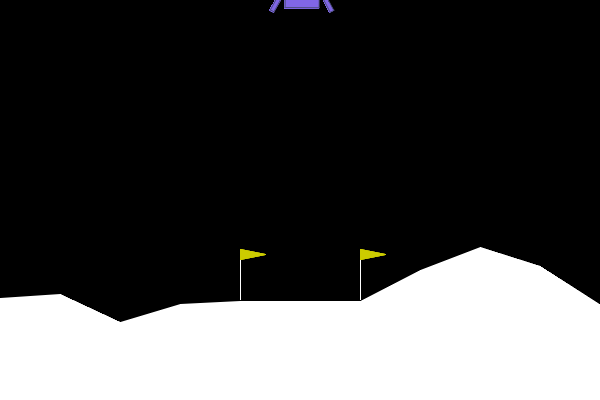

In [12]:
from IPython.display import Image, display
Y = Image(filename="lander_result2.gif", format='gif')
display(Y)

Now, the lander can land, but does not stop firing sideways...

Last step is to try a different algorithm

## Experiment B — PPO

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

def make_env():
    def _init():
        env = gym.make("LunarLander-v3", continuous=False,
                       gravity=-10.0, enable_wind=False,
                       wind_power=15.0, turbulence_power=1.5)
        return Monitor(env)
    return _init

env = DummyVecEnv([make_env()])

model = PPO(
    "MlpPolicy",
    env,
    n_steps=2048,
    batch_size=64,
    gae_lambda=0.95,
    learning_rate=3e-4,
    ent_coef=0.0,
    policy_kwargs=dict(net_arch=[256,256]),
    verbose=1,
    tensorboard_log="./lunar_tensorboard_ppo/"
)

model.learn(total_timesteps=1_000_000)  
model.save("ppo_lunarlander")
env.close()

Using cpu device
Logging to ./lunar_tensorboard_ppo/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.9     |
|    ep_rew_mean     | -188     |
| time/              |          |
|    fps             | 808      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 87.4        |
|    ep_rew_mean          | -163        |
| time/                   |             |
|    fps                  | 532         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009423126 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained

In [ ]:
import imageio
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO

# Load trained model
model = PPO.load("ppo_lunarlander")

env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")
obs, _ = env.reset()

frames = []
done = False

while not done:
    frame = env.render()
    frames.append(frame)

    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

# Save GIF
gif_path = "lander_ppo.gif"
imageio.mimsave(gif_path, frames, fps=30)

env.close()
gif_path

'lander_ppo.gif'

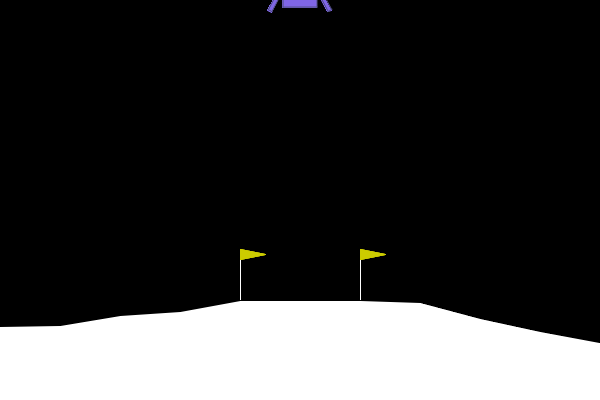

In [13]:
from IPython.display import Image, display
z = Image(filename="lander_ppo.gif", format='gif')
display(z)

Finally, it lands adequately!